Camera calibrated using 20 images


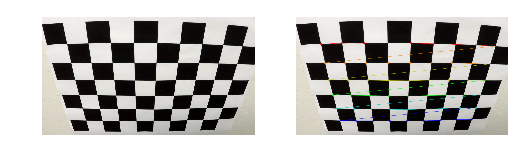

In [24]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []

img, gray, img_corners, img_original = None, None, None, None

objpoints, imgpoints = [], []

image_files = glob.glob('camera_cal/calibration*.jpg')

for fname in image_files:

    nx, ny = 9, 6

    if 'calibration1.jpg' in fname:
        nx, ny = 9, 5
    if 'calibration4.jpg' in fname:
        nx, ny = 6, 5
    if 'calibration5.jpg' in fname:
        nx, ny = 7, 6

    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # Save example image and corresponding identified corners
    if 'calibration2.jpg' in fname:
        img_original = img.copy()
        img_corners = img.copy()
        img_corners = cv2.drawChessboardCorners(img_corners, (nx, ny), corners, ret)
        cv2.imwrite('output_images/chessboard_original.jpg', img_original)
        cv2.imwrite('output_images/chessboard_corners.jpg', img_corners)

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        images.append(img)
    else:
        print('Did not find corners', fname, (nx, ny))

plot_comparison(img_original, img_corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print('Camera calibrated using {0} images'.format(np.array(images).shape[0]))

In [21]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


def plot_comparison(img1, img2):
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.axis('off')

In [ ]:
test_dir = 'test_images'
out_dir = 'output_images'
image_files = glob.glob(test_dir + '/test*.jpg')

for fname in image_files:
    img = cv2.imread(fname)
    undist = undistort(img)
    
    fname = fname.replace(test_dir, out_dir)
    cv2.imwrite(fname, undist)
    
    plot_comparison(img, undist)